Camera calibration

In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
corners_found_dir='output_images/couners_found/'

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, add object points, image points
    if ret == True:
        
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        image_name = os.path.split(fname)[1]
        cv2.drawChessboardCorners(img, (nx ,ny), corners, ret)
        write_name = corners_found_dir + image_name
        cv2.imwrite(write_name, img)
        print("Success to find corners:", write_name)

cv2.destroyAllWindows()

Success to find corners: output_images/couners_found/calibration10.jpg
Success to find corners: output_images/couners_found/calibration11.jpg
Success to find corners: output_images/couners_found/calibration12.jpg
Success to find corners: output_images/couners_found/calibration13.jpg
Success to find corners: output_images/couners_found/calibration14.jpg
Success to find corners: output_images/couners_found/calibration15.jpg
Success to find corners: output_images/couners_found/calibration16.jpg
Success to find corners: output_images/couners_found/calibration17.jpg
Success to find corners: output_images/couners_found/calibration18.jpg
Success to find corners: output_images/couners_found/calibration19.jpg
Success to find corners: output_images/couners_found/calibration2.jpg
Success to find corners: output_images/couners_found/calibration20.jpg
Success to find corners: output_images/couners_found/calibration3.jpg
Success to find corners: output_images/couners_found/calibration6.jpg
Success t

In [3]:
# Save camera distortion
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

print(mtx)
print(dist)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist_pickle.p", "wb" ) )

[[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318544e-04
    2.67124303e-02]]


In [4]:
# Check undistorted images
with open('camera_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

undistorted_dir='output_images/undistorted/'

images = glob.glob('camera_cal/calibration*.jpg')
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image_name=os.path.split(fname)[1]
    write_name = undistorted_dir+image_name
    cv2.imwrite(write_name,dst)
    print("Save undistorted image:", write_name)
cv2.destroyAllWindows()

test_images = glob.glob('test_images/*.jpg')

for idx, fname in enumerate(test_images):
    img = cv2.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    image_name=os.path.split(fname)[1]
    write_name = undistorted_dir+image_name
    cv2.imwrite(write_name,dst)
    print("Save undistorted image:", write_name)
cv2.destroyAllWindows()

Save undistorted image: output_images/undistorted/calibration1.jpg
Save undistorted image: output_images/undistorted/calibration10.jpg
Save undistorted image: output_images/undistorted/calibration11.jpg
Save undistorted image: output_images/undistorted/calibration12.jpg
Save undistorted image: output_images/undistorted/calibration13.jpg
Save undistorted image: output_images/undistorted/calibration14.jpg
Save undistorted image: output_images/undistorted/calibration15.jpg
Save undistorted image: output_images/undistorted/calibration16.jpg
Save undistorted image: output_images/undistorted/calibration17.jpg
Save undistorted image: output_images/undistorted/calibration18.jpg
Save undistorted image: output_images/undistorted/calibration19.jpg
Save undistorted image: output_images/undistorted/calibration2.jpg
Save undistorted image: output_images/undistorted/calibration20.jpg
Save undistorted image: output_images/undistorted/calibration3.jpg
Save undistorted image: output_images/undistorted/c

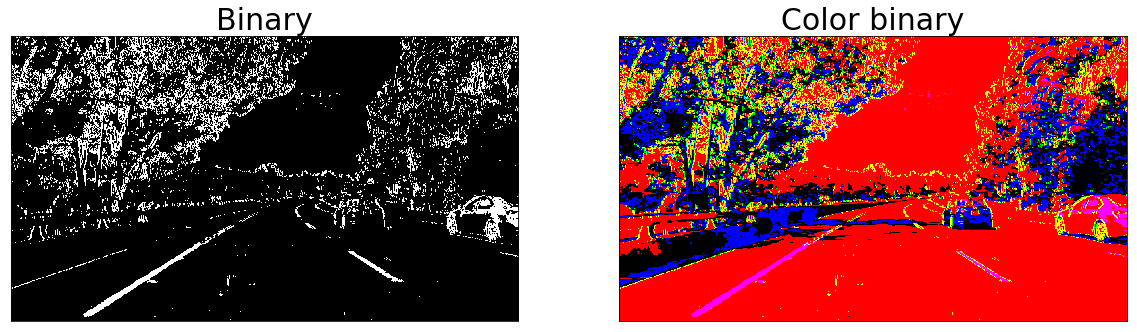

In [4]:
def undistort(img, mtx, dist):
    undist_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_image

def filter_color_and_gradient(img, s_thresh=(120, 255), sx_thresh=(20, 255), l_thresh=(40,255)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    color_binary = np.dstack(( l_binary , sxbinary, s_binary))

    binary = np.zeros_like(sxbinary)
    binary[(l_binary == 1) & (s_binary == 1) | (sxbinary==1)] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            

    return binary, color_binary

test_images = glob.glob('test_images/test5.jpg')

for idx, fname in enumerate(test_images):
    image = plt.imread(fname)
    undist_image = undistort(image, mtx, dist)
    binary,color = filter_color_and_gradient(undist_image)

    # Plot the result
    fig = plt.figure(figsize=(20, 6))
    subplot = fig.add_subplot(1,2,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('Binary', fontsize=30)
    subplot.imshow(binary)

    subplot2 = fig.add_subplot(1,2,2)
    subplot2.set_xticks([])
    subplot2.set_yticks([])
    subplot2.set_title('Color binary', fontsize=30)
    subplot2.imshow(color)
    plt.show()